In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-04-30 23:12:08.060804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 23:12:08.060833: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-04-30 23:12:11.114089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 23:12:11.114117: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 23:12:11.114137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-04-30 23:12:11.114345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 3s 3ms/step - loss: 0.6912 - accuracy: 0.5040 - auc: 0.5656 - val_loss: 0.6734 - val_accuracy: 0.5145 - val_auc: 0.7066
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5191 - auc: 0.6229 - val_loss: 0.6661 - val_accuracy: 0.5152 - val_auc: 0.7819
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6736 - accuracy: 0.5296 - auc: 0.6504 - val_loss: 0.6601 - val_accuracy: 0.5235 - val_auc: 0.8242
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.5432 - auc: 0.6744 - val_loss: 0.6538 - val_accuracy: 0.5365 - val_auc: 0.8569
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6607 - accuracy: 0.5597 - auc: 0.6996 - val_loss: 0.6471 - val_accuracy: 0.5616 - val_auc: 0.8792
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6531 - accuracy: 0.5787 - auc: 0.7208 - val_loss: 0.6390 - val_ac

391/391 [==============================] - 1s 3ms/step - loss: 0.4808 - accuracy: 0.7836 - auc: 0.8718 - val_loss: 0.4076 - val_accuracy: 0.8986 - val_auc: 0.9749
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7962 - auc: 0.8829 - val_loss: 0.3817 - val_accuracy: 0.8942 - val_auc: 0.9781
Epoch 11/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4344 - accuracy: 0.8050 - auc: 0.8911 - val_loss: 0.3553 - val_accuracy: 0.8966 - val_auc: 0.9806
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4151 - accuracy: 0.8135 - auc: 0.8994 - val_loss: 0.3361 - val_accuracy: 0.8939 - val_auc: 0.9826
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3982 - accuracy: 0.8212 - auc: 0.9064 - val_loss: 0.3171 - val_accuracy: 0.8957 - val_auc: 0.9842
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3841 - accuracy: 0.8256 - auc: 0.9121 - val_loss: 0.2993 - v

Epoch 60/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2953 - accuracy: 0.8698 - auc: 0.9484 - val_loss: 0.2265 - val_accuracy: 0.9020 - val_auc: 0.9922
Epoch 61/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2961 - accuracy: 0.8700 - auc: 0.9482 - val_loss: 0.2279 - val_accuracy: 0.9006 - val_auc: 0.9922
Epoch 62/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2916 - accuracy: 0.8726 - auc: 0.9498 - val_loss: 0.2246 - val_accuracy: 0.9018 - val_auc: 0.9924
Epoch 63/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2922 - accuracy: 0.8728 - auc: 0.9492 - val_loss: 0.2268 - val_accuracy: 0.9005 - val_auc: 0.9924
Epoch 64/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2895 - accuracy: 0.8728 - auc: 0.9505 - val_loss: 0.2294 - val_accuracy: 0.8971 - val_auc: 0.9925
Epoch 65/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2893 - accuracy: 0.8733 - auc: 0.9505 - val_loss

Epoch 68/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2716 - accuracy: 0.8817 - auc: 0.9560 - val_loss: 0.2269 - val_accuracy: 0.8921 - val_auc: 0.9924
Epoch 69/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2703 - accuracy: 0.8818 - auc: 0.9565 - val_loss: 0.2301 - val_accuracy: 0.8884 - val_auc: 0.9926
Epoch 70/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2694 - accuracy: 0.8821 - auc: 0.9566 - val_loss: 0.2290 - val_accuracy: 0.8895 - val_auc: 0.9926
Epoch 71/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2705 - accuracy: 0.8821 - auc: 0.9565 - val_loss: 0.2340 - val_accuracy: 0.8849 - val_auc: 0.9926
Epoch 72/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2666 - accuracy: 0.8839 - auc: 0.9576 - val_loss: 0.2291 - val_accuracy: 0.8892 - val_auc: 0.9926
Epoch 73/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2676 - accuracy: 0.8839 - auc: 0.9572 - val_loss

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2506 - accuracy: 0.8918 - auc: 0.9622 - val_loss: 0.2583 - val_accuracy: 0.8673 - val_auc: 0.9931
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2484 - accuracy: 0.8924 - auc: 0.9628 - val_loss: 0.2610 - val_accuracy: 0.8657 - val_auc: 0.9931
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2494 - accuracy: 0.8921 - auc: 0.9625 - val_loss: 0.2621 - val_accuracy: 0.8654 - val_auc: 0.9930
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2479 - accuracy: 0.8929 - auc: 0.9629 - val_loss: 0.2601 - val_accuracy: 0.8666 - val_auc: 0.9931
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2462 - accuracy: 0.8939 - auc: 0.9633 - val_loss: 0.2630 - val_accuracy: 0.8656 - val_auc: 0.9931
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2458 - accuracy: 0.8942 - auc: 0.9638 - val_loss

Epoch 2/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.2877 - accuracy: 0.8743 - auc: 0.9492 - val_loss: 0.2358 - val_accuracy: 0.8819 - val_auc: 0.9844
Epoch 3/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.2757 - accuracy: 0.8807 - auc: 0.9533 - val_loss: 0.2647 - val_accuracy: 0.8564 - val_auc: 0.9826
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.20925326645374298, 'epoch': 1}, 'best_auc': {'auc': 0.9843769073486328, 'epoch': 2}, 'best_accuracy': {'accuracy': 0.9122499823570251, 'epoch': 1}}
Epoch 1/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.5692 - accuracy: 0.6912 - auc: 0.7950 - val_loss: 0.3678 - val_accuracy: 0.8737 - val_auc: 0.9731
Epoch 2/4
12512/12512 [==============================] - 19s 2ms/step - loss: 0.3733 - accuracy: 0.8293 - auc: 0.9141 - val_loss: 0.2562 - val_accuracy: 0.8917 - val_auc: 0.9872
Epoch 3/4
12512/12512 [======================

Epoch 6/7
12512/12512 [==============================] - 28s 2ms/step - loss: 0.3142 - accuracy: 0.8648 - auc: 0.9411 - val_loss: 0.2353 - val_accuracy: 0.9065 - val_auc: 0.9764
Epoch 7/7
12512/12512 [==============================] - 35s 3ms/step - loss: 0.3118 - accuracy: 0.8666 - auc: 0.9421 - val_loss: 0.2169 - val_accuracy: 0.9161 - val_auc: 0.9774
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.19654123485088348, 'epoch': 4}, 'best_auc': {'auc': 0.9789807200431824, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9193000197410583, 'epoch': 4}}
Epoch 1/7
12512/12512 [==============================] - 23s 2ms/step - loss: 0.3656 - accuracy: 0.8361 - auc: 0.9197 - val_loss: 0.2439 - val_accuracy: 0.9038 - val_auc: 0.9747
Epoch 2/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.3322 - accuracy: 0.8557 - auc: 0.9346 - val_loss: 0.3007 - val_accuracy: 0.8579 - val_auc: 0.9729
Epoch 3/7
12512/12512 [======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.3436 - accuracy: 0.8485 - auc: 0.9280 - val_loss: 0.2545 - val_accuracy: 0.8998 - val_auc: 0.9778
Epoch 2/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.3269 - accuracy: 0.8639 - auc: 0.9332 - val_loss: 0.2054 - val_accuracy: 0.9230 - val_auc: 0.9809
Epoch 3/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.3262 - accuracy: 0.8692 - auc: 0.9325 - val_loss: 0.1955 - val_accuracy: 0.9136 - val_auc: 0.9808


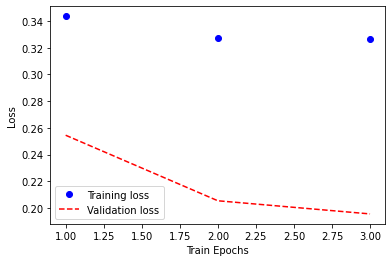

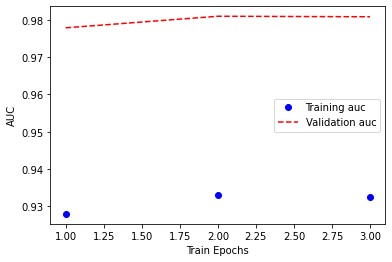

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

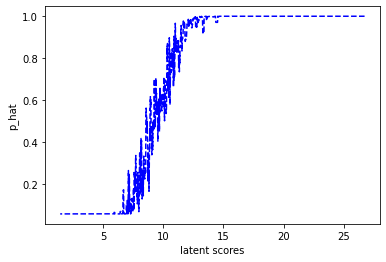

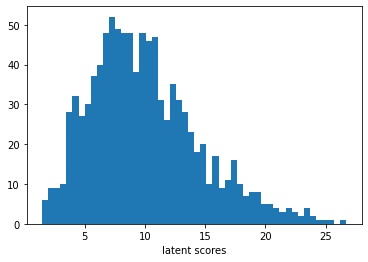

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

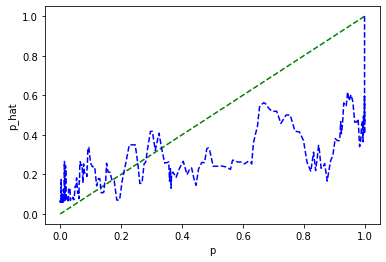

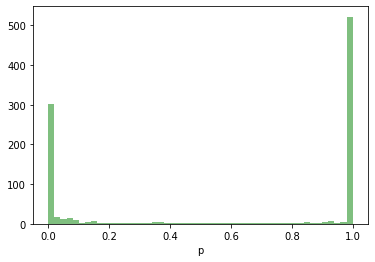

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

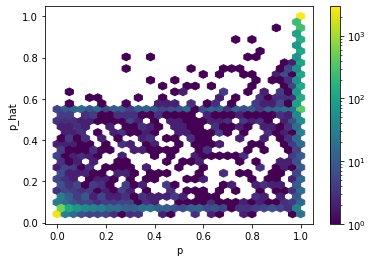

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

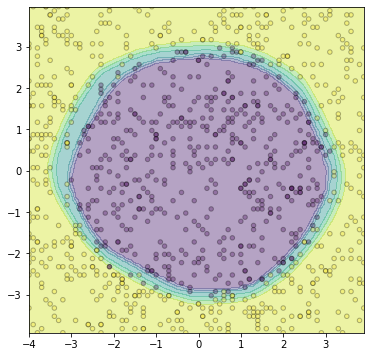

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.1765032410621643, 'epoch': 3},
 'best_auc': {'auc': 0.983971118927002, 'epoch': 3},
 'best_accuracy': {'accuracy': 0.9248499870300293, 'epoch': 2},
 'model': <keras.engine.sequential.Sequential at 0x7fe8bc0fd3a0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25127625465393066, 'epoch': 35},
  'best_auc': {'auc': 0.9898719787597656, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9117000102996826, 'epoch': 21}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25938814878463745, 'epoch': 28},
  'best_auc': {'auc': 0.9904299974441528, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.8998500108718872, 'epoch': 17}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25786396861076355, 'epoch': 22},
  'best_auc': {'auc': 0.9907238483428955, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9010000228881836, 'epoch': 14}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.22154362499713898, 'epoch': 84},
  'best_auc': {'auc': 0.9934026002883911, 'epoch': 84},
  'best_accur

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25